Cleaned column names: ['Timestamp(ms)', 'Temperature(C)', 'PredictedTemperature(C)']
Available columns: ['Timestamp(ms)', 'Temperature(C)', 'PredictedTemperature(C)']
Could not find column 'Temperature(°C)'. Using the second column (index 1) instead.


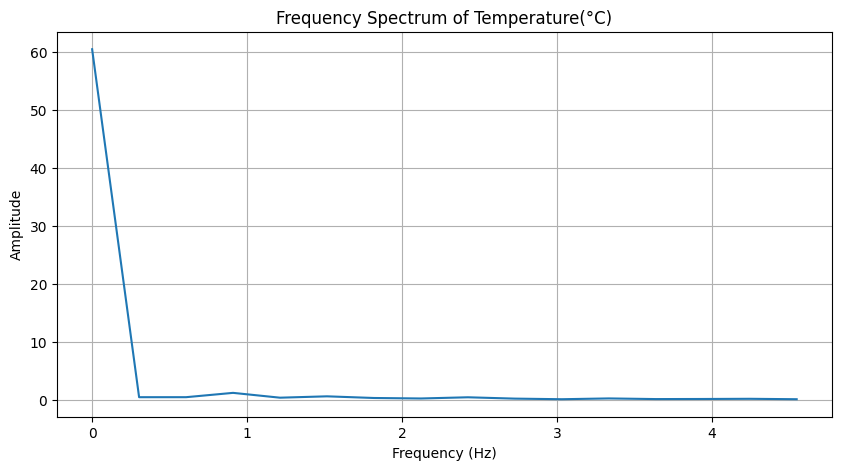

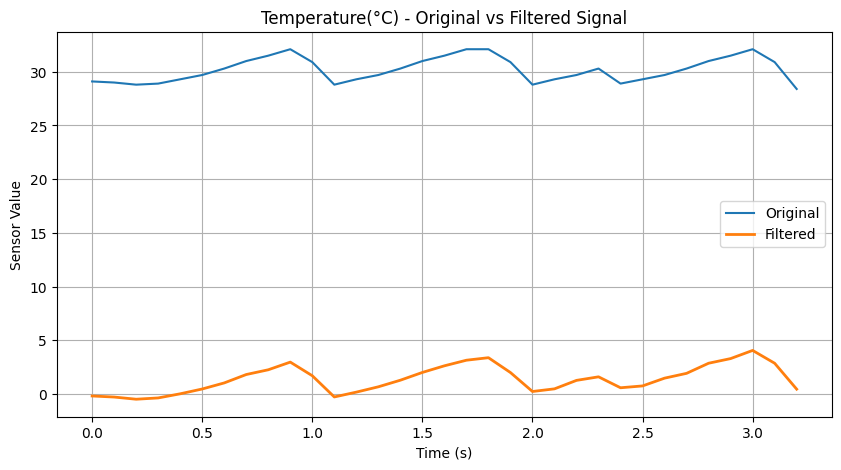

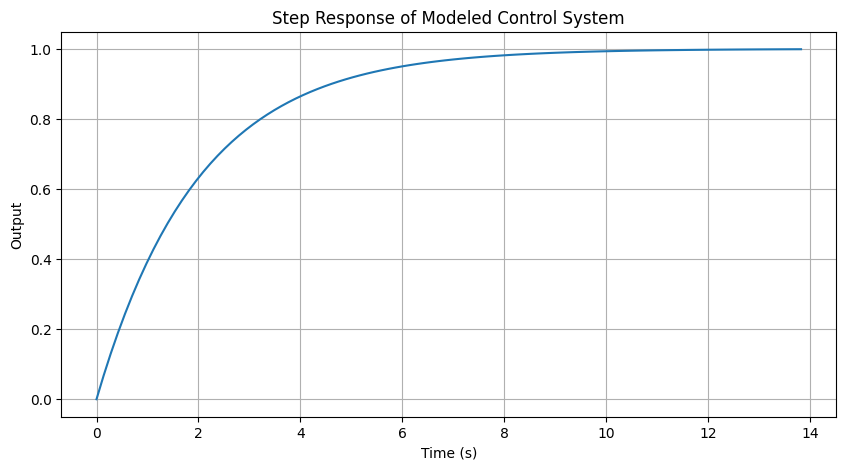

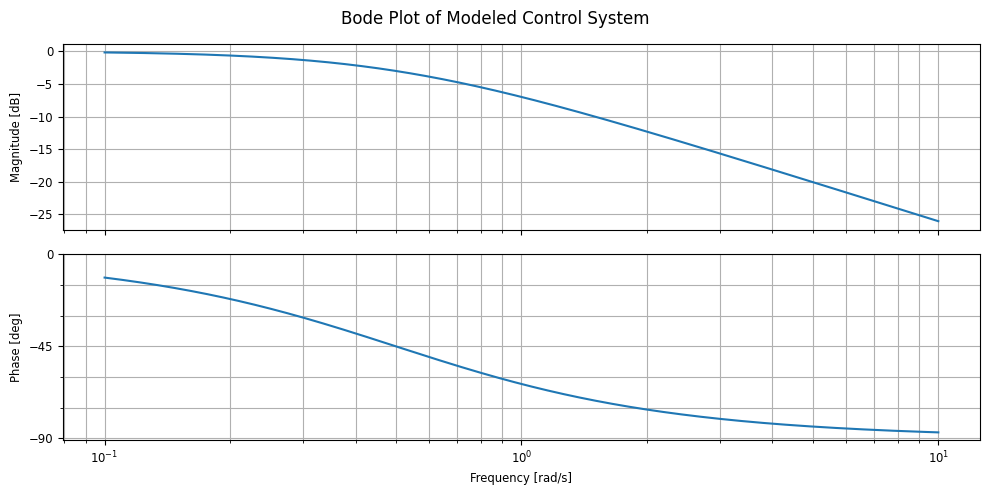


System Poles: [-0.5+0.j]
System is stable.

--- Fourier Analysis Summary ---
Sampling Frequency: 10.00 Hz
Top 5 Dominant Frequencies (Hz): [0.         0.90909091 1.51515152 0.60606061 0.3030303 ]

--- Control System Summary ---
Transfer Function G(s) = 1.0 / (2.0s + 1)
Poles: [-0.5+0.j]


In [19]:
#LOCKHUB - Mathematical Foundation Enhancement

# Install required packages (only run once)
!pip install control scipy matplotlib pandas numpy

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
import control as ctrl

# Load the CSV file
filename = "LockHub_DHT.csv"
data = pd.read_csv(filename)

# Clean up column headers (strip invisible characters like non-breaking space)
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace('\u202f', '', regex=False)
data.columns = data.columns.str.replace('\xa0', '', regex=False)
# Added this line to handle potential byte order marks:
data.columns = data.columns.str.replace('\ufeff', '', regex=False)

# Print to confirm cleanup
print("Cleaned column names:", data.columns.tolist())

# Assign correct column names after cleaning
time_col = 'Timestamp(ms)'
sensor_col = 'Temperature(°C)'  # You can change to 'PredictedTemperature(°C)' if preferred

# ----> Updated to handle potential name mismatches:
try:
    # First, try accessing with the expected name
    time = data[time_col].values / 1000.0
    signal = data[sensor_col].values
except KeyError:
    # If KeyError, print available columns for debugging
    print("Available columns:", data.columns.tolist())
    # Then, offer an alternative way to access, by name or index:
    if sensor_col not in data.columns:
        if 'Temperature(°C)' in data.columns:
            sensor_col = 'Temperature(°C)'
            print(f"Using column '{sensor_col}' instead.")
            signal = data[sensor_col].values
        else:
            print(f"Could not find column '{sensor_col}'. Using the second column (index 1) instead.")
            signal = data.iloc[:, 1].values # Use the second column (index 1)
    else:
        signal = data[sensor_col].values

# Compute sampling interval and frequency
# Assuming the original timestamps aren't correct or that you want to analyze a different period and you want to resample to 10 Hz
# Change 10 to your desired sampling frequency
desired_fs = 10 # Hz
dt = 1 / desired_fs
fs = desired_fs

# Create a time vector with the desired sampling rate (optional if timestamps aren't needed)
# Comment this out if you don't need a new time vector or have accurate timestamps in your data.
time = np.arange(0, len(signal) * dt, dt)

# -----------------------------
# 1. Fourier Series Analysis
# -----------------------------
N = len(signal)
yf = fft(signal)
xf = fftfreq(N, dt)[:N//2]

# Plot frequency spectrum
plt.figure(figsize=(10, 5)) # Set consistent figure size
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title(f"Frequency Spectrum of {sensor_col}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Bandpass filter definition
def bandpass_filter(signal, lowcut, highcut, fs, order=3): # Changed order to 3
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Check if the normalized frequencies are within the valid range (0, 1)
    if low >= 1 or high >= 1:
        raise ValueError(f"The cutoff frequencies ({lowcut}, {highcut}) are too high for the sampling frequency ({fs}). "
                         f"The normalized frequencies ({low:.2f}, {high:.2f}) must be within the range (0, 1).")
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Apply filter
filtered_signal = bandpass_filter(signal, lowcut=0.1, highcut=4.5, fs=fs) # highcut already adjusted

# Plot original vs filtered
plt.figure(figsize=(10, 5)) # Set consistent figure size
plt.plot(time, signal, label='Original')
plt.plot(time, filtered_signal, label='Filtered', linewidth=2)
plt.legend()
plt.title(f"{sensor_col} - Original vs Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Sensor Value")
plt.grid()
plt.show()

# -----------------------------
# 2. Laplace Transform Modeling
# -----------------------------
# First-order transfer function: G(s) = K / (τs + 1)
K = 1.0     # Gain
tau = 2.0   # Time constant (tweak this based on response)

# Define transfer function
num = [K]
den = [tau, 1]
G = ctrl.TransferFunction(num, den)

# Step response
t_out, y_out = ctrl.step_response(G)
plt.figure(figsize=(10, 5)) # Set consistent figure size
plt.plot(t_out, y_out)
plt.title("Step Response of Modeled Control System")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.grid()
plt.show()

# Bode plot
plt.figure(figsize=(10, 5)) # Set consistent figure size
ctrl.bode(G, dB=True)
plt.suptitle("Bode Plot of Modeled Control System")
plt.show()

# Check poles (stability)
poles = G.poles() # Corrected line
print("\nSystem Poles:", poles)
if np.all(np.real(poles) < 0):
    print("System is stable.")
else:
    print("System is unstable.")

# -----------------------------
# 3. Summary Outputs
# -----------------------------
dominant_freqs = xf[np.argsort(np.abs(yf[:N//2]))[::-1][:5]]

print("\n--- Fourier Analysis Summary ---")
print(f"Sampling Frequency: {fs:.2f} Hz")
print("Top 5 Dominant Frequencies (Hz):", dominant_freqs)

print("\n--- Control System Summary ---")
print(f"Transfer Function G(s) = {K} / ({tau}s + 1)")  # Fixed: Closing parenthesis added
print("Poles:", poles)